### 📌VGG11

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理（VGG 使用 ImageNet 预训练，因此需归一化到 ImageNet 均值）
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 加载 CIFAR-10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# 加载预训练 VGG11 模型
model = models.vgg11(pretrained=True)

# 修改最后一层为 10 类（适配 CIFAR-10）
model.classifier[6] = nn.Linear(4096, 10)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练函数
def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Accuracy: {100*correct/total:.2f}%")

# 简单训练 5 轮
for epoch in range(5):
    train(model, trainloader, criterion, optimizer, epoch)


100%|██████████| 170M/170M [00:17<00:00, 9.89MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [00:02<00:00, 234MB/s]


Epoch 1, Loss: 353.357, Accuracy: 84.31%
Epoch 2, Loss: 178.327, Accuracy: 92.26%
Epoch 3, Loss: 114.879, Accuracy: 94.97%
Epoch 4, Loss: 89.658, Accuracy: 96.16%
Epoch 5, Loss: 64.870, Accuracy: 97.27%


In [ ]:
conv_layers = [(name, m) for name, m in model.features.named_modules() if isinstance(m, nn.Conv2d)]
layer_names = [name for name, _ in conv_layers]

In [ ]:
# 准确率评估函数
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
model_vgg11 = deepcopy(model)
prune_rates = [0.1, 0.3, 0.5, 0.7, 0.9]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/MyDrive/第二次尝试/VGG11_C10_layer_sensitivity.pth")


Mounted at /content/drive


Layer 0, prune rate 0.1, Accuracy: 91.25%
Layer 0, prune rate 0.3, Accuracy: 90.27%
Layer 0, prune rate 0.5, Accuracy: 83.54%
Layer 0, prune rate 0.7, Accuracy: 64.00%
Layer 0, prune rate 0.9, Accuracy: 10.74%
Layer 3, prune rate 0.1, Accuracy: 91.33%
Layer 3, prune rate 0.3, Accuracy: 91.46%
Layer 3, prune rate 0.5, Accuracy: 91.35%
Layer 3, prune rate 0.7, Accuracy: 90.82%
Layer 3, prune rate 0.9, Accuracy: 82.18%
Layer 6, prune rate 0.1, Accuracy: 91.35%
Layer 6, prune rate 0.3, Accuracy: 91.28%
Layer 6, prune rate 0.5, Accuracy: 91.32%
Layer 6, prune rate 0.7, Accuracy: 90.25%
Layer 6, prune rate 0.9, Accuracy: 82.32%
Layer 8, prune rate 0.1, Accuracy: 91.34%
Layer 8, prune rate 0.3, Accuracy: 91.31%
Layer 8, prune rate 0.5, Accuracy: 91.49%
Layer 8, prune rate 0.7, Accuracy: 90.67%
Layer 8, prune rate 0.9, Accuracy: 79.12%
Layer 11, prune rate 0.1, Accuracy: 91.39%
Layer 11, prune rate 0.3, Accuracy: 91.35%
Layer 11, prune rate 0.5, Accuracy: 91.05%
Layer 11, prune rate 0.7, Accur

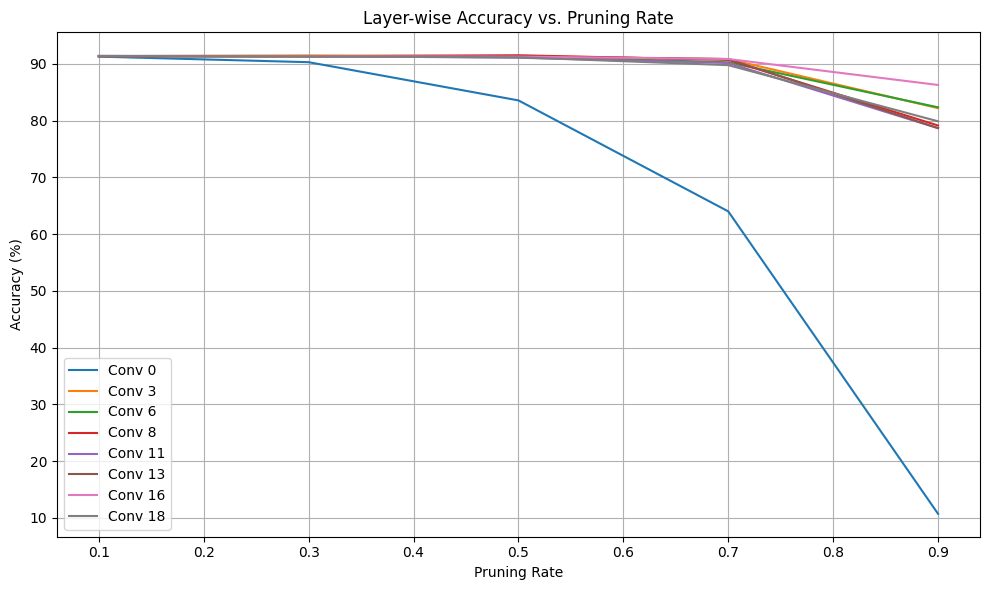

In [ ]:
import copy
import matplotlib.pyplot as plt
results = {name: [] for name in layer_names}
# 遍历每层，分别施加不同剪枝率
for name, _ in conv_layers:
    for rate in prune_rates:
        model_copy = copy.deepcopy(model).to(device)
        layer_dict = dict(model_copy.features.named_modules())
        prune.l1_unstructured(layer_dict[name], name="weight", amount=rate)
        acc = evaluate(model_copy)
        results[name].append(acc)
        print(f"Layer {name}, prune rate {rate:.1f}, Accuracy: {acc:.2f}%")

# 📊 可视化
plt.figure(figsize=(10, 6))
for name in layer_names:
    plt.plot(prune_rates, results[name], label=f"Conv {name}")
plt.xlabel("Pruning Rate")
plt.ylabel("Accuracy (%)")
plt.title("VGG11 Layer-wise Accuracy vs. Pruning Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 📌MobileNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据增强和归一化
transform_train = transforms.Compose([
    transforms.Resize(224),  # MobileNet 输入为224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 CIFAR-10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# 加载预训练 MobileNet_v2 并修改输出为10类
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 10)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型 5 个 epoch
for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1}/5 - Loss: {running_loss:.3f}, Train Acc: {acc:.2f}%")



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 216MB/s]


Epoch 1/5 - Loss: 405.807, Train Acc: 82.44%
Epoch 2/5 - Loss: 269.542, Train Acc: 88.12%
Epoch 3/5 - Loss: 220.699, Train Acc: 90.36%
Epoch 4/5 - Loss: 196.284, Train Acc: 91.40%
Epoch 5/5 - Loss: 180.446, Train Acc: 92.16%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/MyDrive/第二次尝试/MobileNet_V2_layer_sensitivity.pth")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Layer: 0.0, Prune Rate: 0.1, Accuracy: 89.69%
Layer: 0.0, Prune Rate: 0.3, Accuracy: 89.65%
Layer: 0.0, Prune Rate: 0.5, Accuracy: 89.75%
Layer: 0.0, Prune Rate: 0.7, Accuracy: 86.82%
Layer: 0.0, Prune Rate: 0.9, Accuracy: 68.31%
Layer: 1.conv.0.0, Prune Rate: 0.1, Accuracy: 89.70%
Layer: 1.conv.0.0, Prune Rate: 0.3, Accuracy: 89.59%
Layer: 1.conv.0.0, Prune Rate: 0.5, Accuracy: 82.20%
Layer: 1.conv.0.0, Prune Rate: 0.7, Accuracy: 58.21%
Layer: 1.conv.0.0, Prune Rate: 0.9, Accuracy: 18.29%
Layer: 1.conv.1, Prune Rate: 0.1, Accuracy: 89.69%
Layer: 1.conv.1, Prune Rate: 0.3, Accuracy: 89.74%
Layer: 1.conv.1, Prune Rate: 0.5, Accuracy: 88.75%
Layer: 1.conv.1, Prune Rate: 0.7, Accuracy: 60.37%
Layer: 1.conv.1, Prune Rate: 0.9, Accuracy: 38.38%
Layer: 2.conv.0.0, Prune Rate: 0.1, Accuracy: 89.68%
Layer: 2.conv.0.0, Prune Rate: 0.3, Accuracy: 89.48%
Layer: 2.conv.0.0, Prune Rate: 0.5, Accuracy: 89.70%
Layer: 2.conv.0.0, Prune Rate: 0.7, Accuracy: 88.60%
Layer: 2.conv.0.0, Prune Rate: 0.9, Ac

/tmp/ipython-input-3979075456.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


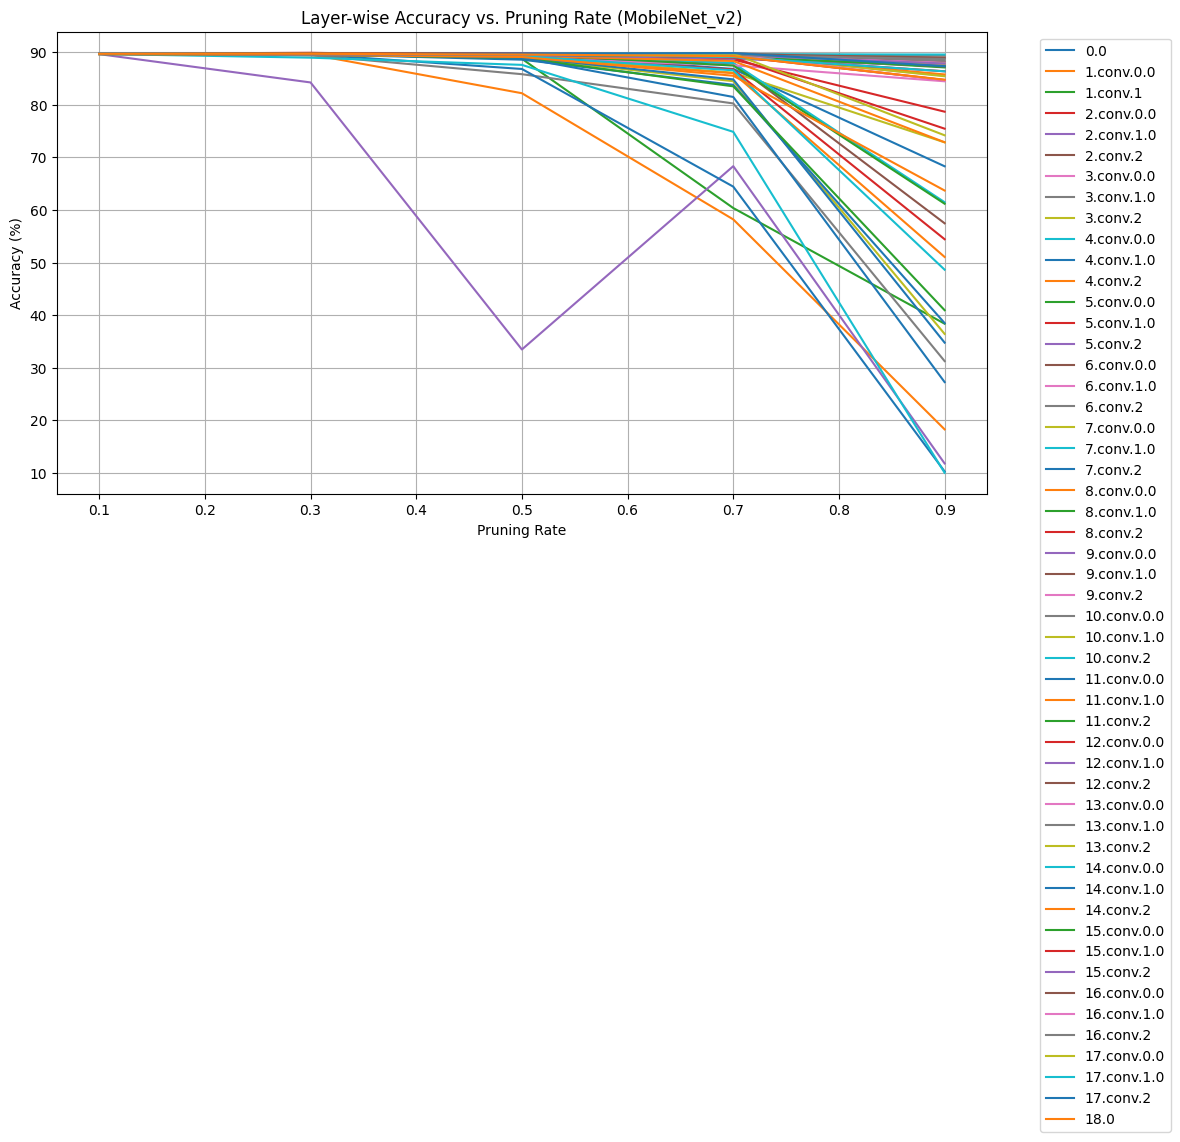

In [ ]:
# ✅ 获取 MobileNet_v2 中所有卷积层
conv_layers = [(name, m) for name, m in model.features.named_modules() if isinstance(m, nn.Conv2d)]
layer_names = [name for name, _ in conv_layers]

# ✅ 设置剪枝率
prune_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
results = {name: [] for name in layer_names}

# ✅ 遍历每一层和每一种剪枝率
for name, _ in conv_layers:
    for rate in prune_rates:
        model_copy = copy.deepcopy(model).to(device)
        layer_dict = dict(model_copy.features.named_modules())
        prune.l1_unstructured(layer_dict[name], name='weight', amount=rate)
        acc = evaluate(model_copy)
        results[name].append(acc)
        print(f"Layer: {name}, Prune Rate: {rate}, Accuracy: {acc:.2f}%")

# ✅ 可视化
plt.figure(figsize=(12, 6))
for name in layer_names:
    plt.plot(prune_rates, results[name], label=name)
plt.xlabel("Pruning Rate")
plt.ylabel("Accuracy (%)")
plt.title("Layer-wise Accuracy vs. Pruning Rate (MobileNet_v2)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### 📌ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

# ✅ 1. 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ✅ 4. 加载 ResNet18 并修改最后一层为10分类
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# ✅ 5. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ 6. 训练 5 个 Epoch
for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}/5 - Loss: {running_loss:.3f} - Train Accuracy: {train_acc:.2f}%")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


Epoch 1/5 - Loss: 434.419 - Train Accuracy: 80.85%
Epoch 2/5 - Loss: 265.400 - Train Accuracy: 88.32%
Epoch 3/5 - Loss: 207.515 - Train Accuracy: 90.98%
Epoch 4/5 - Loss: 166.734 - Train Accuracy: 92.67%
Epoch 5/5 - Loss: 137.412 - Train Accuracy: 94.01%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/MyDrive/第二次尝试/ResNet18_layer_sensitivity.pth")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conv_layers = [(name, m) for name, m in model.named_modules() if isinstance(m, nn.Conv2d)]
layer_names = [name for name, _ in conv_layers]
selected_layers = [conv_layers[i] for i in list(range(3)) + list(range(-3, 0))]
# ✅ 剪枝率
prune_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

# ✅ 存储结果
results = {name: [] for name, _ in selected_layers}

# ✅ 循环剪枝+评估
for name, _ in selected_layers:
    print(f"\n🔍 Testing selected layer: {name}")
    for rate in prune_rates:
        model_copy = copy.deepcopy(model).to(device)
        layer_dict = dict(model_copy.named_modules())
        prune.l1_unstructured(layer_dict[name], name='weight', amount=rate)
        acc = evaluate(model_copy)
        results[name].append(acc)
        print(f"  🟡 Prune rate {rate:.1f} → Accuracy: {acc:.2f}%")


🔍 Testing selected layer: conv1
  🟡 Prune rate 0.1 → Accuracy: 90.19%
  🟡 Prune rate 0.3 → Accuracy: 90.26%
  🟡 Prune rate 0.5 → Accuracy: 90.69%
  🟡 Prune rate 0.7 → Accuracy: 90.21%
  🟡 Prune rate 0.9 → Accuracy: 76.91%

🔍 Testing selected layer: layer1.0.conv1
  🟡 Prune rate 0.1 → Accuracy: 90.19%
  🟡 Prune rate 0.3 → Accuracy: 90.23%
  🟡 Prune rate 0.5 → Accuracy: 90.35%
  🟡 Prune rate 0.7 → Accuracy: 90.21%
  🟡 Prune rate 0.9 → Accuracy: 88.63%

🔍 Testing selected layer: layer1.0.conv2
  🟡 Prune rate 0.1 → Accuracy: 90.16%
  🟡 Prune rate 0.3 → Accuracy: 90.19%
  🟡 Prune rate 0.5 → Accuracy: 90.18%
  🟡 Prune rate 0.7 → Accuracy: 90.14%
  🟡 Prune rate 0.9 → Accuracy: 89.92%

🔍 Testing selected layer: layer4.0.downsample.0
  🟡 Prune rate 0.1 → Accuracy: 90.20%
  🟡 Prune rate 0.3 → Accuracy: 90.14%
  🟡 Prune rate 0.5 → Accuracy: 89.98%
  🟡 Prune rate 0.7 → Accuracy: 90.05%
  🟡 Prune rate 0.9 → Accuracy: 89.06%

🔍 Testing selected layer: layer4.1.conv1
  🟡 Prune rate 0.1 → Accuracy: 9

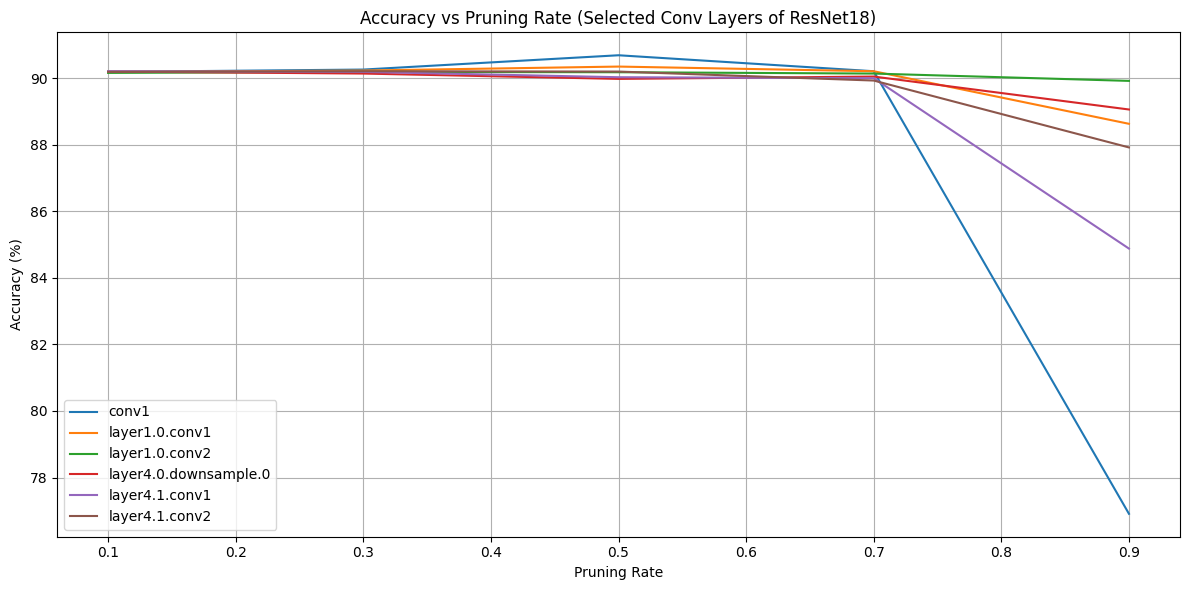

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for name in results:
    plt.plot(prune_rates, results[name], label=name)

plt.xlabel("Pruning Rate")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Pruning Rate (Selected Conv Layers of ResNet18)")
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()
